In [1]:
import torch
import torch.functional as func
import torch.nn as nn

import numpy as np
import random
import tqdm
import argparse
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics

from models.Network import Face_Detection_Model, rgbdp_v1_twostep_model, rgbdp_v2_twostep_model, rgbdp_v3_twostep_model

import os
import os.path as osp
from re import S

import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T 
import matplotlib.pyplot as plt
# from dataloader.dataloader import load_dataset, load_test_dataset

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

rgb_model = Face_Detection_Model(3, True).to(device)
basic_model = rgbdp_v3_twostep_model(device=device)
cloudnet = rgbdp_v1_twostep_model(device=device)
cloudnet_v2 = rgbdp_v2_twostep_model(device=device)

rgb = torch.load("/mnt/nas4/yrkim/liveness_lidar_project/GC_project/bc_output/checkpoint/0825_total_rgb/epoch_300_model.pth")
basic = torch.load("/mnt/nas4/yrkim/liveness_lidar_project/GC_project/bc_output/checkpoint/0828_total_rgbdp_v3/epoch_420_model.pth")
cloud_v2 = torch.load("/mnt/nas4/yrkim/liveness_lidar_project/GC_project/bc_output/checkpoint/0828_total_rgbdp_v2/epoch_232_model.pth")

rgb_model.load_state_dict(rgb['model_state_dict'])
basic_model.load_state_dict(basic['model_state_dict'])
cloudnet_v2.load_state_dict(cloud_v2['model_state_dict'])

sigmoid = nn.Sigmoid()
loss_fn = nn.BCEWithLogitsLoss()

g = torch.Generator()
g.manual_seed(1)

def seed_worker(worker_id):
    np.random.seed(1)
    random.seed(1)        

In [3]:
class Face_Data(Dataset):

    def __init__(self, data_paths, crop=False):
        self.data_paths = data_paths
        self.crop = crop
        
        normalize = T.Normalize(mean=[0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
        self.transforms = T.Compose([
            T.ToTensor(),
            normalize
        ])   
        self.transforms2 = T.Compose([
            T.ToTensor()
        ])               
    
    def __getitem__(self, index):
        rgb_path = self.data_paths[index][0]
        cloud_path = self.data_paths[index][1]
        depth_path = self.data_paths[index][2]   
             
        # crop setting
        crop_width = 90
        crop_height = 150
        mid_x, mid_y = 90, 90
        offset_x, offset_y = crop_width//2, crop_height//2
        
        # RGB open and crop 
        rgb_data = cv2.imread(rgb_path)
        rgb_data = cv2.cvtColor(rgb_data, cv2.COLOR_BGR2RGB)
        rgb_data = cv2.resize(rgb_data, (180,180), interpolation=cv2.INTER_CUBIC)
        if self.crop == True:
            rgb_data = rgb_data[mid_y-offset_y:mid_y+offset_y, mid_x-offset_x:mid_x+offset_x]     
        if self.transforms is not None :
            rgb_data = self.transforms(rgb_data)
            
        # Depth open 
        depth_data = cv2.imread(depth_path)
        depth_data = cv2.cvtColor(depth_data, cv2.COLOR_BGR2GRAY)
        depth_data = cv2.resize(depth_data, (180,180), interpolation=cv2.INTER_CUBIC)        
        if self.transforms2 is not None :
            depth_data = self.transforms2(depth_data)            
            
        # Point Cloud(192, 256, 3) open and crop 
        cloud_data = np.load(cloud_path)
        cloud_data = cv2.resize(cloud_data, (180,180), interpolation=cv2.INTER_CUBIC)
        cloud_data += 5
        if self.crop == True:
            cloud_data = cloud_data[mid_y-offset_y:mid_y+offset_y, mid_x-offset_x:mid_x+offset_x]
        
        # Point Cloud and Depth Scaling
        shift_value = 0
        xcoor = np.array(cloud_data[:, :, 0] + shift_value)
        ycoor = np.array(cloud_data[:, :, 1] + shift_value)
        zcoor = np.array(cloud_data[:, :, 2] + shift_value)
        # depth = np.array(cloud_data[:, :, 3] + shift_value)

        # Stadardivation
        # xcoor = (xcoor-xcoor.mean())/xcoor.std()
        # ycoor = (ycoor-ycoor.mean())/ycoor.std()
        # zcoor = (zcoor-zcoor.mean())/zcoor.std()
        # depth = (depth-depth.mean())/depth.std()    
        
        # Min Max         
        xcoor = (xcoor-xcoor.min())/(xcoor.max()-xcoor.min())
        ycoor = (ycoor-ycoor.min())/(ycoor.max()-ycoor.min())
        zcoor = (zcoor-zcoor.min())/(zcoor.max()-zcoor.min())
        # depth = (depth-depth.min())/(depth.max()-depth.min())  
        
        scaled_cloud_data = np.concatenate([xcoor[np.newaxis,:],ycoor[np.newaxis,:],zcoor[np.newaxis,:]]) 
        # scaled_depth_data = depth[np.newaxis,:]
        
        # label - { 0 : real , 1 : mask }
        if 'bonafide' in rgb_path :
            label = 0
        elif 'attack_mask' in rgb_path :
            label = 1
        elif 'attack_replay' in rgb_path :
            label = 1
        elif 'attack_paper' in rgb_path :
            label = 1
        # return rgb_data, scaled_cloud_data, scaled_depth_data, label
        return rgb_data, scaled_cloud_data, depth_data, label
    def __len__(self):
        return len(self.data_paths)
    
    
def load_dataset(args): 
        
    ## Input : RGB(3-channel) + Depth(1-channel) + Point_Cloud(3-channel)
    data_path = '/mnt/nas3/yrkim/liveness_lidar_project/GC_project/LDFAS/1. Indoor'
    npy_path = '/mnt/nas3/yrkim/liveness_lidar_project/GC_project/LDFAS/NPY_Files/1. Indoor'

    traindata_count = [i for i in range(1,10)] # 1~9
    testdata_count = [i for i in range(10,13)]  # 10~12    
 
    train_img_paths = []
    for i in traindata_count :
        img_path = osp.join(data_path, str(i), 'bonafide')
        files = os.listdir(img_path)
        rgbs = [j for j in files if (j.split('.')[-1]=='jpg') and (j.split('_')[0]=='rgb')]
        depths = [j for j in files if (j.split('.')[-1]=='jpg') and (j.split('_')[0]=='depth')]
        random.shuffle(rgbs)
        random.shuffle(depths)
        
        # RGB 
        bonafide_files = [osp.join(data_path, str(i), 'bonafide', j) for j in rgbs]
        paper_files= [osp.join(data_path, str(i), 'attack_paper', j) for j in rgbs]
        replay_files= [osp.join(data_path, str(i), 'attack_replay', j) for j in rgbs]
        mask_files= [osp.join(data_path, str(i), 'attack_mask', j) for j in rgbs]
        
        # Depth
        bonafide_depths = [osp.join(data_path, str(i), 'bonafide', j) for j in depths]
        paper_depths= [osp.join(data_path, str(i), 'attack_paper', j) for j in depths]
        replay_depths= [osp.join(data_path, str(i), 'attack_replay', j) for j in depths]
        mask_depths= [osp.join(data_path, str(i), 'attack_mask', j) for j in depths]       
        
        # Point Cloud
        bonafide_cloud_files = [osp.join(npy_path, 'real_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in bonafide_files]
        paper_cloud_files = [osp.join(npy_path, 'paper_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in paper_files]
        replay_cloud_files = [osp.join(npy_path, 'replay_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in replay_files]
        mask_cloud_files = [osp.join(npy_path, 'mask_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in mask_files]
        
        # bonafide
        train_img_paths += list(zip(bonafide_files,bonafide_cloud_files,bonafide_depths))[:]
        
        # PAs
        if "p" in args:
            train_img_paths += list(zip(paper_files,paper_cloud_files,paper_depths))[:]
        if "r" in args:
            train_img_paths += list(zip(replay_files,replay_cloud_files,replay_depths))[:]
        if "m" in args:
            train_img_paths += list(zip(mask_files,mask_cloud_files,mask_depths))[:]
 
    test_img_paths = []
    for i in testdata_count :
        img_path = osp.join(data_path, str(i), 'bonafide')
        files = os.listdir(img_path)
        rgbs = [j for j in files if (j.split('.')[-1]=='jpg') and (j.split('_')[0]=='rgb')]
        depths = [j for j in files if (j.split('.')[-1]=='jpg') and (j.split('_')[0]=='depth')]
        random.shuffle(rgbs)
        random.shuffle(depths)
        
        # RGB
        bonafide_files = [osp.join(data_path, str(i), 'bonafide', j) for j in rgbs]
        paper_files= [osp.join(data_path, str(i), 'attack_paper', j) for j in rgbs]
        replay_files= [osp.join(data_path, str(i), 'attack_replay', j) for j in rgbs]
        mask_files= [osp.join(data_path, str(i), 'attack_mask', j) for j in rgbs]
        
        # Depth
        bonafide_depths = [osp.join(data_path, str(i), 'bonafide', j) for j in depths]
        paper_depths= [osp.join(data_path, str(i), 'attack_paper', j) for j in depths]
        replay_depths= [osp.join(data_path, str(i), 'attack_replay', j) for j in depths]
        mask_depths= [osp.join(data_path, str(i), 'attack_mask', j) for j in depths]        
        
        # Point Cloud
        bonafide_cloud_files = [osp.join(npy_path, 'real_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in bonafide_files]
        paper_cloud_files = [osp.join(npy_path, 'paper_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in paper_files]
        replay_cloud_files = [osp.join(npy_path, 'replay_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in replay_files]
        mask_cloud_files = [osp.join(npy_path, 'mask_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in mask_files]
        
        # bonafide
        test_img_paths += list(zip(bonafide_files,bonafide_cloud_files,bonafide_depths))[:]
        
        # PAs
        if "p" in args:
            test_img_paths += list(zip(paper_files,paper_cloud_files,paper_depths))[:]
        if "r" in args:
            test_img_paths += list(zip(replay_files,replay_cloud_files,replay_depths))[:]
        if "m" in args:
            test_img_paths += list(zip(mask_files,mask_cloud_files,mask_depths))[:]
        
    random.shuffle(train_img_paths)
    random.shuffle(test_img_paths)

    print(len(train_img_paths))
    print(len(test_img_paths))
    
#     train_dataset=Face_Data(train_img_paths, False)
#     test_dataset=Face_Data(test_img_paths, False) 

    return train_img_paths, test_img_paths


def load_test_dataset(args, dir_name): 
        
    ## Input : RGB(3-channel) + Depth(1-channel) + Point_Cloud(3-channel)
    LDFAS_path = '/mnt/nas3/yrkim/liveness_lidar_project/GC_project/LDFAS/'
    data_path = osp.join(LDFAS_path, dir_name)
    npy_path = osp.join(LDFAS_path, "NPY_Files", dir_name)
         
    testdata_count = [i for i in range(1,13)]  # 1~12    
#     testdata_count = [i for i in range(7,13)]  # 1~12    
    test_img_paths = []
    for i in testdata_count :
        img_path = osp.join(data_path, str(i), 'bonafide')
        files = os.listdir(img_path)
        rgbs = [j for j in files if (j.split('.')[-1]=='jpg') and (j.split('_')[0]=='rgb')]
        depths = [j for j in files if (j.split('.')[-1]=='jpg') and (j.split('_')[0]=='depth')]
        random.shuffle(rgbs)
        random.shuffle(depths)
        
        # RGB
        bonafide_files = [osp.join(data_path, str(i), 'bonafide', j) for j in rgbs]
        paper_files= [osp.join(data_path, str(i), 'attack_paper', j) for j in rgbs]
        replay_files= [osp.join(data_path, str(i), 'attack_replay', j) for j in rgbs]
        mask_files= [osp.join(data_path, str(i), 'attack_mask', j) for j in rgbs]
        
        # Depth
        bonafide_depths = [osp.join(data_path, str(i), 'bonafide', j) for j in depths]
        paper_depths= [osp.join(data_path, str(i), 'attack_paper', j) for j in depths]
        replay_depths= [osp.join(data_path, str(i), 'attack_replay', j) for j in depths]
        mask_depths= [osp.join(data_path, str(i), 'attack_mask', j) for j in depths]        
               
        # Point Cloud
        bonafide_cloud_files = [osp.join(npy_path, 'real_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in bonafide_files]
        paper_cloud_files = [osp.join(npy_path, 'paper_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in paper_files]
        replay_cloud_files = [osp.join(npy_path, 'replay_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in replay_files]
        mask_cloud_files = [osp.join(npy_path, 'mask_cloud_data',j.split('/')[-3], 
                                (('pc_'+j.split('/')[-1].split('_')[-1]).split('.')[0]+'.npy')) for j in mask_files]
        
        # bonafide
        test_img_paths += list(zip(bonafide_files,bonafide_cloud_files,bonafide_depths))[:]
        
        # PAs
        if "p" in args:
            test_img_paths += list(zip(paper_files,paper_cloud_files,paper_depths))[:]
        if "r" in args:
            test_img_paths += list(zip(replay_files,replay_cloud_files,replay_depths))[:]
        if "m" in args:
            test_img_paths += list(zip(mask_files,mask_cloud_files,mask_depths))[:]
     
    random.shuffle(test_img_paths)
    print(len(test_img_paths))
    
#     test_dataset=Face_Data(test_img_paths, False) 

    return test_img_paths


In [4]:
args = "rpm"

indoor_train_paths, indoor_test_paths = load_dataset(args)
outdoor_test_paths = load_test_dataset(args, "2. Outdoor")
darkdoor_test_pathst = load_test_dataset(args, "3. Indoor_dark")

indoor_trainset=Face_Data(indoor_train_paths, False)
indoor_testset=Face_Data(indoor_test_paths, False)
outdoor_testset=Face_Data(outdoor_test_paths, False)
darkdoor_testset=Face_Data(darkdoor_test_pathst, False)

# indoor_dataset = indoor_trainset
indoor_dataset = indoor_testset
# indoor_dataset = torch.utils.data.ConcatDataset([indoor_trainset, indoor_testset])

indoor_dataloader= DataLoader(indoor_dataset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=seed_worker, generator=g)
outdoor_dataloader = DataLoader(outdoor_testset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=seed_worker, generator=g)
darkdoor_dataloader = DataLoader(darkdoor_testset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=seed_worker, generator=g)    

720
240
960
960


In [5]:
rgb_model.eval()
basic_model.eval()
cloudnet.eval()
cloudnet_v2.eval()

perform_rgb = {"indoor_true":[], "indoor_prob":[], "outdoor_true":[], "outdoor_prob":[], "darkdoor_true":[], "darkdoor_prob":[]}
perform_basic = {"indoor_true":[], "indoor_prob":[], "outdoor_true":[], "outdoor_prob":[], "darkdoor_true":[], "darkdoor_prob":[]}
perform_cloud_v2 = {"indoor_true":[], "indoor_prob":[], "outdoor_true":[], "outdoor_prob":[], "darkdoor_true":[], "darkdoor_prob":[]}

indoor_feature = {"rgb":[], "basic":[], "cloudnet":[]}
outdoor_feature = {"rgb":[], "basic":[], "cloudnet":[]}
darkdoor_feature = {"rgb":[], "basic":[], "cloudnet":[]}

In [6]:
in_label = []

for idx,data in enumerate(indoor_dataloader) : 
    rgb, cloud, depth, label = data
    rgb = rgb.float().to(device)
    cloud = cloud.float().to(device)
    depth = depth.float().to(device)
    label = label.float().to(device)

    logits_rgb = rgb_model(rgb)
    logits_basic = basic_model(rgb, depth, cloud)
    logits_cloud_v2 = cloudnet_v2(rgb, depth, cloud)

    for i in range(4):
        indoor_feature["rgb"].append(logits_rgb.cpu().detach().numpy()[i])
        indoor_feature["basic"].append(logits_basic.cpu().detach().numpy()[i])
        indoor_feature["cloudnet"].append(logits_cloud_v2.cpu().detach().numpy()[i])
        in_label.append(label.cpu().detach().numpy()[i])

in_rgb_feature = np.array(indoor_feature["rgb"])
in_basic_feature = np.array(indoor_feature["basic"])
in_cloud_feature = np.array(indoor_feature["cloudnet"])
in_label = np.array(in_label)

print(in_rgb_feature.shape)
print(in_basic_feature.shape)
print(in_cloud_feature.shape)
print(in_label.shape)

(240, 512)
(240, 512)
(240, 1024)
(240,)


In [7]:
out_label = []

for data in outdoor_dataloader : 
    rgb, cloud, depth, label = data
    rgb = rgb.float().to(device)
    cloud = cloud.float().to(device)
    depth = depth.float().to(device)
    label = label.float().to(device)

    logits_rgb = rgb_model(rgb)
    logits_basic = basic_model(rgb, depth, cloud)
    logits_cloud_v2 = cloudnet_v2(rgb, depth, cloud)
    
    for i in range(4):
        outdoor_feature["rgb"].append(logits_rgb.cpu().detach().numpy()[i])
        outdoor_feature["basic"].append(logits_basic.cpu().detach().numpy()[i])
        outdoor_feature["cloudnet"].append(logits_cloud_v2.cpu().detach().numpy()[i])
        out_label.append(label.cpu().detach().numpy()[i])

out_rgb_feature = np.array(outdoor_feature["rgb"])
out_basic_feature = np.array(outdoor_feature["basic"])
out_cloud_feature = np.array(outdoor_feature["cloudnet"])
out_label = np.array(out_label)        
    
    
dark_label = []

for data in darkdoor_dataloader : 
    rgb, cloud, depth, label = data
    rgb = rgb.float().to(device)
    cloud = cloud.float().to(device)
    depth = depth.float().to(device)
    label = label.float().to(device)

    logits_rgb = rgb_model(rgb)
    logits_basic = basic_model(rgb, depth, cloud)
    logits_cloud_v2 = cloudnet_v2(rgb, depth, cloud)

    for i in range(4):
        darkdoor_feature["rgb"].append(logits_rgb.cpu().detach().numpy()[i])
        darkdoor_feature["basic"].append(logits_basic.cpu().detach().numpy()[i])
        darkdoor_feature["cloudnet"].append(logits_cloud_v2.cpu().detach().numpy()[i])
        dark_label.append(label.cpu().detach().numpy()[i])
  
dark_rgb_feature = np.array(darkdoor_feature["rgb"])
dark_basic_feature = np.array(darkdoor_feature["basic"])
dark_cloud_feature = np.array(darkdoor_feature["cloudnet"])
dark_label = np.array(dark_label)  

print(out_rgb_feature.shape)
print(out_basic_feature.shape)
print(out_cloud_feature.shape)
print(out_label.shape)

print(dark_rgb_feature.shape)
print(dark_basic_feature.shape)
print(dark_cloud_feature.shape)
print(dark_label.shape)

(960, 512)
(960, 512)
(960, 1024)
(960,)
(960, 512)
(960, 512)
(960, 1024)
(960,)


In [8]:
def compare(perplexity, indoor_score, outdoor_score, darkdoor_score):
    
    bona_indoor_list = []
    if indoor_score["rgb_bonafide"] < indoor_score["basic_bonafide"] and indoor_score["rgb_bonafide"] < indoor_score["cloud_bonafide"]:         
        bona_indoor_list.append(1)
        if indoor_score["basic_bonafide"] > indoor_score["cloud_bonafide"]:
            bona_indoor_list.append(3)
            bona_indoor_list.append(2)
        else:
            bona_indoor_list.append(2)
            bona_indoor_list.append(3)
    elif indoor_score["rgb_bonafide"] > indoor_score["basic_bonafide"] and indoor_score["rgb_bonafide"] > indoor_score["cloud_bonafide"]:
        bona_indoor_list.append(3)
        if indoor_score["basic_bonafide"] > indoor_score["cloud_bonafide"]:
            bona_indoor_list.append(2)
            bona_indoor_list.append(1)
        else:
            bona_indoor_list.append(1)
            bona_indoor_list.append(2)
    else:
        if indoor_score["basic_bonafide"] > indoor_score["cloud_bonafide"]:
            bona_indoor_list.append(2)
            bona_indoor_list.append(3)
            bona_indoor_list.append(1)
        else:
            bona_indoor_list.append(2)
            bona_indoor_list.append(1)
            bona_indoor_list.append(3)        

    bona_outdoor_list = []
    if outdoor_score["rgb_bonafide"] < outdoor_score["basic_bonafide"] and outdoor_score["rgb_bonafide"] < outdoor_score["cloud_bonafide"]:         
        bona_outdoor_list.append(1)
        if outdoor_score["basic_bonafide"] > outdoor_score["cloud_bonafide"]:
            bona_outdoor_list.append(3)
            bona_outdoor_list.append(2)
        else:
            bona_outdoor_list.append(2)
            bona_outdoor_list.append(3)
    elif outdoor_score["rgb_bonafide"] > outdoor_score["basic_bonafide"] and outdoor_score["rgb_bonafide"] > outdoor_score["cloud_bonafide"]:
        bona_outdoor_list.append(3)
        if outdoor_score["basic_bonafide"] > outdoor_score["cloud_bonafide"]:
            bona_outdoor_list.append(2)
            bona_outdoor_list.append(1)
        else:
            bona_outdoor_list.append(1)
            bona_outdoor_list.append(2)
    else:
        if outdoor_score["basic_bonafide"] > outdoor_score["cloud_bonafide"]:
            bona_outdoor_list.append(2)
            bona_outdoor_list.append(3)
            bona_outdoor_list.append(1)
        else:
            bona_outdoor_list.append(2)
            bona_outdoor_list.append(1)
            bona_outdoor_list.append(3)               
     
    bona_darkdoor_list = []
    if darkdoor_score["rgb_bonafide"] < darkdoor_score["basic_bonafide"] and darkdoor_score["rgb_bonafide"] < darkdoor_score["cloud_bonafide"]:         
        bona_darkdoor_list.append(1)
        if darkdoor_score["basic_bonafide"] > darkdoor_score["cloud_bonafide"]:
            bona_darkdoor_list.append(3)
            bona_darkdoor_list.append(2)
        else:
            bona_darkdoor_list.append(2)
            bona_darkdoor_list.append(3)
    elif darkdoor_score["rgb_bonafide"] >darkdoor_score["basic_bonafide"] and darkdoor_score["rgb_bonafide"] > darkdoor_score["cloud_bonafide"]:
        bona_darkdoor_list.append(3)
        if darkdoor_score["basic_bonafide"] > darkdoor_score["cloud_bonafide"]:
            bona_darkdoor_list.append(2)
            bona_darkdoor_list.append(1)
        else:
            bona_darkdoor_list.append(1)
            bona_darkdoor_list.append(2)
    else:
        if darkdoor_score["basic_bonafide"] > darkdoor_score["cloud_bonafide"]:
            bona_darkdoor_list.append(2)
            bona_darkdoor_list.append(3)
            bona_darkdoor_list.append(1)
        else:
            bona_darkdoor_list.append(2)
            bona_darkdoor_list.append(1)
            bona_darkdoor_list.append(3)               
              
                
                
    spoof_indoor_list = []
    if indoor_score["rgb_spoofing"] < indoor_score["basic_spoofing"] and indoor_score["rgb_spoofing"] < indoor_score["cloud_spoofing"]:         
        spoof_indoor_list.append(1)
        if indoor_score["basic_spoofing"] > indoor_score["cloud_spoofing"]:
            spoof_indoor_list.append(3)
            spoof_indoor_list.append(2)
        else:
            spoof_indoor_list.append(2)
            spoof_indoor_list.append(3)
    elif indoor_score["rgb_spoofing"] > indoor_score["basic_spoofing"] and indoor_score["rgb_spoofing"] > indoor_score["cloud_spoofing"]:
        spoof_indoor_list.append(3)
        if indoor_score["basic_spoofing"] > indoor_score["cloud_spoofing"]:
            spoof_indoor_list.append(2)
            spoof_indoor_list.append(1)
        else:
            spoof_indoor_list.append(1)
            spoof_indoor_list.append(2)
    else:
        if indoor_score["basic_spoofing"] > indoor_score["cloud_spoofing"]:
            spoof_indoor_list.append(2)
            spoof_indoor_list.append(3)
            spoof_indoor_list.append(1)
        else:
            spoof_indoor_list.append(2)
            spoof_indoor_list.append(1)
            spoof_indoor_list.append(3)        

    spoof_outdoor_list = []
    if outdoor_score["rgb_spoofing"] < outdoor_score["basic_spoofing"] and outdoor_score["rgb_spoofing"] < outdoor_score["cloud_spoofing"]:         
        spoof_outdoor_list.append(1)
        if outdoor_score["basic_spoofing"] > outdoor_score["cloud_spoofing"]:
            spoof_outdoor_list.append(3)
            spoof_outdoor_list.append(2)
        else:
            spoof_outdoor_list.append(2)
            spoof_outdoor_list.append(3)
    elif outdoor_score["rgb_spoofing"] > outdoor_score["basic_spoofing"] and outdoor_score["rgb_spoofing"] > outdoor_score["cloud_spoofing"]:
        spoof_outdoor_list.append(3)
        if outdoor_score["basic_spoofing"] > outdoor_score["cloud_spoofing"]:
            spoof_outdoor_list.append(2)
            spoof_outdoor_list.append(1)
        else:
            spoof_outdoor_list.append(1)
            spoof_outdoor_list.append(2)
    else:
        if outdoor_score["basic_spoofing"] > outdoor_score["cloud_spoofing"]:
            spoof_outdoor_list.append(2)
            spoof_outdoor_list.append(3)
            spoof_outdoor_list.append(1)
        else:
            spoof_outdoor_list.append(2)
            spoof_outdoor_list.append(1)
            spoof_outdoor_list.append(3)               
     
    spoof_darkdoor_list = []
    if darkdoor_score["rgb_spoofing"] < darkdoor_score["basic_spoofing"] and darkdoor_score["rgb_spoofing"] < darkdoor_score["cloud_spoofing"]:         
        spoof_darkdoor_list.append(1)
        if darkdoor_score["basic_spoofing"] > darkdoor_score["cloud_spoofing"]:
            spoof_darkdoor_list.append(3)
            spoof_darkdoor_list.append(2)
        else:
            spoof_darkdoor_list.append(2)
            spoof_darkdoor_list.append(3)
    elif darkdoor_score["rgb_spoofing"] >darkdoor_score["basic_spoofing"] and darkdoor_score["rgb_spoofing"] > darkdoor_score["cloud_spoofing"]:
        spoof_darkdoor_list.append(3)
        if darkdoor_score["basic_spoofing"] > darkdoor_score["cloud_spoofing"]:
            spoof_darkdoor_list.append(2)
            spoof_darkdoor_list.append(1)
        else:
            spoof_darkdoor_list.append(1)
            spoof_darkdoor_list.append(2)
    else:
        if darkdoor_score["basic_spoofing"] > darkdoor_score["cloud_spoofing"]:
            spoof_darkdoor_list.append(2)
            spoof_darkdoor_list.append(3)
            spoof_darkdoor_list.append(1)
        else:
            spoof_darkdoor_list.append(2)
            spoof_darkdoor_list.append(1)
            spoof_darkdoor_list.append(3)                  
                
                
    print(f"perplexity: {perplexity}") 
    print("Bonafide")
    print("Indoor: \t", *bona_indoor_list)
    print("Outdoor: \t", *bona_outdoor_list)
    print("Darkdoor: \t", *bona_darkdoor_list)
    print("Spoofing")
    print("Indoor: \t", *spoof_indoor_list)
    print("Outdoor: \t", *spoof_outdoor_list)
    print("Darkdoor: \t", *spoof_darkdoor_list)
    print("")

In [9]:
in_cloud_feature.shape

(240, 1024)

In [51]:
indoor_perplexity = 30 # 100
perplexity = 500
n_iter = 1000    # 3000

in_rgb_em = TSNE(n_components=2, perplexity=indoor_perplexity, n_iter=n_iter).fit_transform(in_rgb_feature)
in_basic_em = TSNE(n_components=2, perplexity=indoor_perplexity, n_iter=n_iter).fit_transform(in_basic_feature)
in_cloud_em = TSNE(n_components=2, perplexity=indoor_perplexity, n_iter=n_iter).fit_transform(in_cloud_feature)

out_rgb_em = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter).fit_transform(out_rgb_feature)
out_basic_em = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter).fit_transform(out_basic_feature)
out_cloud_em = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter).fit_transform(out_cloud_feature)

dark_rgb_em = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter).fit_transform(dark_rgb_feature)
dark_basic_em = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter).fit_transform(dark_basic_feature)
dark_cloud_em = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter).fit_transform(dark_cloud_feature)

indoor_df = pd.DataFrame()
indoor_df["rgb_x"] = in_rgb_em[:,0]
indoor_df["rgb_y"] = in_rgb_em[:,1]
indoor_df["basic_x"] = in_basic_em[:,0]
indoor_df["basic_y"] = in_basic_em[:,1]
indoor_df["cloud_x"] = in_cloud_em[:,0]
indoor_df["cloud_y"] = in_cloud_em[:,1]
indoor_df["label"] = in_label

outdoor_df = pd.DataFrame()
outdoor_df["rgb_x"] = out_rgb_em[:,0]
outdoor_df["rgb_y"] = out_rgb_em[:,1]
outdoor_df["basic_x"] = out_basic_em[:,0]
outdoor_df["basic_y"] = out_basic_em[:,1]
outdoor_df["cloud_x"] = out_cloud_em[:,0]
outdoor_df["cloud_y"] = out_cloud_em[:,1]
outdoor_df["label"] = out_label

darkdoor_df = pd.DataFrame()
darkdoor_df["rgb_x"] = dark_rgb_em[:,0]
darkdoor_df["rgb_y"] = dark_rgb_em[:,1]
darkdoor_df["basic_x"] = dark_basic_em[:,0]
darkdoor_df["basic_y"] = dark_basic_em[:,1]
darkdoor_df["cloud_x"] = dark_cloud_em[:,0]
darkdoor_df["cloud_y"] = dark_cloud_em[:,1]
darkdoor_df["label"] = dark_label

In [52]:
def calSOS(median, df, model):
    tsne_x = f"{model}_x"
    tsne_y = f"{model}_y"
    
    dist = []
    for i in range(df.shape[0]):
        point = df.iloc[i][tsne_x], df.iloc[i][tsne_y]
        dist.append(distance.euclidean(median,point))

    return sum(dist) / len(dist)


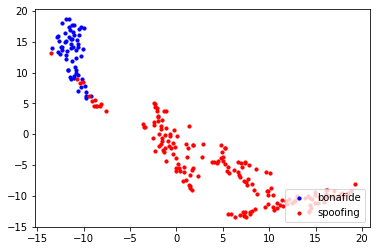

Distance by mean : 25.781984329223633
Bonafide - Sum of Squares : 3.0452273522814113
Spoofing - Sum of Squares : 8.15472982832127


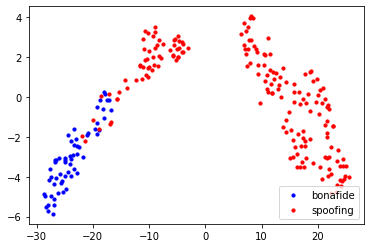

Distance by mean : 35.894981384277344
Bonafide - Sum of Squares : 3.117610717813174
Spoofing - Sum of Squares : 11.592105248901579


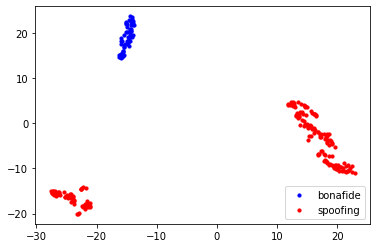

Distance by mean : 40.68375778198242
Bonafide - Sum of Squares : 2.454918124030034
Spoofing - Sum of Squares : 18.384303331375122


In [53]:
from scipy.spatial import distance

c1 = indoor_df[indoor_df['label']==0]
c2 = indoor_df[indoor_df['label']==1]

model = ["rgb", "basic", "cloud"]

for name in model:
    tsne_x = f"{name}_x"
    tsne_y = f"{name}_y"    
    
#     plt.title("Indoor-"+ name)            
#     plt.scatter(c1[tsne_x],c1[tsne_y],color='skyblue',s=10,label='bonafide')
#     plt.scatter(c2[tsne_x],c2[tsne_y],color='coral',s=10,label='spoofing')
    plt.scatter(c1[tsne_x],c1[tsne_y],color='blue',s=10,label='bonafide')
    plt.scatter(c2[tsne_x],c2[tsne_y],color='red',s=10,label='spoofing')
    c1_m = c1[tsne_x].median(),c1[tsne_y].median()
    c2_m = c2[tsne_x].median(),c2[tsne_y].median()
#     plt.scatter(c1_m[0],c1_m[1],color='blue',s=100,label='m_bonafide',marker='*')
#     plt.scatter(c2_m[0],c2_m[1], color='red',s=100,label='m_spoofing',marker='*')
    plt.legend(loc="lower right")
    plt.show()
    
    print('Distance by mean :',distance.euclidean(c1_m,c2_m))
    print('Bonafide - Sum of Squares :', calSOS(c1_m, c1, name))
    print('Spoofing - Sum of Squares :', calSOS(c2_m, c2, name))
#     break


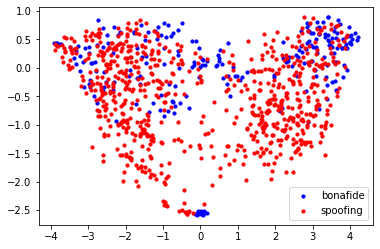

Distance by mean : 0.8740787506103516
Bonafide - Sum of Squares : 2.406950876008098
Spoofing - Sum of Squares : 2.2179171678661884


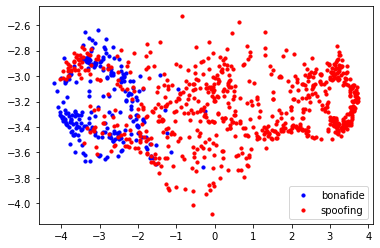

Distance by mean : 3.6388003826141357
Bonafide - Sum of Squares : 0.6977956797461957
Spoofing - Sum of Squares : 1.949428893191119


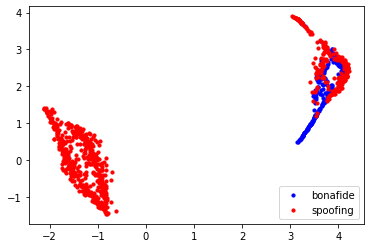

Distance by mean : 4.939997673034668
Bonafide - Sum of Squares : 0.7129672196422082
Spoofing - Sum of Squares : 2.367699905950576


In [54]:
from scipy.spatial import distance

c1 = outdoor_df[outdoor_df['label']==0]
c2 = outdoor_df[outdoor_df['label']==1]

model = ["rgb", "basic", "cloud"]

for name in model:
    tsne_x = f"{name}_x"
    tsne_y = f"{name}_y"
    
    
#     plt.title("Outdoor-"+ name)            
#     plt.scatter(c1[tsne_x],c1[tsne_y],color='skyblue',s=10,label='bonafide')
#     plt.scatter(c2[tsne_x],c2[tsne_y],color='coral',s=10,label='spoofing')
    plt.scatter(c1[tsne_x],c1[tsne_y],color='blue',s=10,label='bonafide')
    plt.scatter(c2[tsne_x],c2[tsne_y],color='red',s=10,label='spoofing')

    c1_m = c1[tsne_x].median(),c1[tsne_y].median()
    c2_m = c2[tsne_x].median(),c2[tsne_y].median()
#     plt.scatter(c1_m[0],c1_m[1],color='blue',s=100,label='m_bonafide',marker='*')
#     plt.scatter(c2_m[0],c2_m[1], color='red',s=100,label='m_spoofing',marker='*')
    plt.legend(loc="lower right")
    plt.show()
    
    print('Distance by mean :',distance.euclidean(c1_m,c2_m))
    print('Bonafide - Sum of Squares :', calSOS(c1_m, c1, name))
    print('Spoofing - Sum of Squares :', calSOS(c2_m, c2, name))
#     break


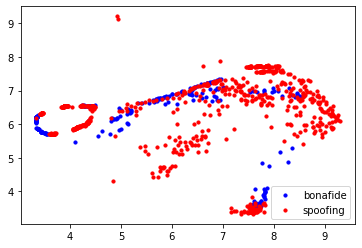

Distance by mean : 1.1855329275131226
Bonafide - Sum of Squares : 1.8332507851844033
Spoofing - Sum of Squares : 2.062002672456826


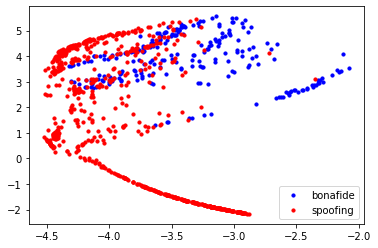

Distance by mean : 2.7364940643310547
Bonafide - Sum of Squares : 0.9520559514251848
Spoofing - Sum of Squares : 2.23717739675194


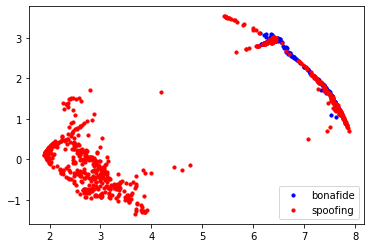

Distance by mean : 4.492028713226318
Bonafide - Sum of Squares : 0.8424735900674326
Spoofing - Sum of Squares : 2.0799854840255447


In [55]:
from scipy.spatial import distance

c1 = darkdoor_df[darkdoor_df['label']==0]
c2 = darkdoor_df[darkdoor_df['label']==1]

model = ["rgb", "basic", "cloud"]


for name in model:
    tsne_x = f"{name}_x"
    tsne_y = f"{name}_y"
    
    
#     plt.title("Darkdoor-"+ name)            
#     plt.scatter(c1[tsne_x],c1[tsne_y],color='skyblue',s=10,label='bonafide')
#     plt.scatter(c2[tsne_x],c2[tsne_y],color='coral',s=10,label='spoofing')
    plt.scatter(c1[tsne_x],c1[tsne_y],color='blue',s=10,label='bonafide')
    plt.scatter(c2[tsne_x],c2[tsne_y],color='red',s=10,label='spoofing')
    c1_m = c1[tsne_x].median(),c1[tsne_y].median()
    c2_m = c2[tsne_x].median(),c2[tsne_y].median()

#     plt.scatter(c1_m[0],c1_m[1],color='blue',s=100,label='m_bonafide',marker='*')
#     plt.scatter(c2_m[0],c2_m[1], color='red',s=100,label='m_spoofing',marker='*')
    plt.legend(loc="lower right")
    plt.show()
    
    print('Distance by mean :',distance.euclidean(c1_m,c2_m))
    print('Bonafide - Sum of Squares :', calSOS(c1_m, c1, name))
    print('Spoofing - Sum of Squares :', calSOS(c2_m, c2, name))
#     break


In [ ]:
# c1 = indoor_df[indoor_df['label']==0]
# c2 = indoor_df[indoor_df['label']==1]

# model = ["rgb", "basic", "cloud"]
# indoor_score = {"rgb_bonafide":[], "basic_bonafide":[], "cloud_bonafide":[],
#          "rgb_spoofing":[], "basic_spoofing":[], "cloud_spoofing":[]}

# for name in model:
#     tsne_x = f"{name}_x"
#     tsne_y = f"{name}_y"
    
#     mean_x = c1.mean()
    
    
#     plt.title("Indoor-"+ name)            
#     plt.scatter(c1[tsne_x],c1[tsne_y],color='red',label='class0')
#     plt.scatter(c2[tsne_x],c2[tsne_y],color='blue',label='class1')
#     plt.show()
    
#     bonafide = []
#     for i, x in enumerate(c1[tsne_x]):
#         for j, y in enumerate(c1[tsne_y]):
#             if i == j:
#                 bonafide.append([x, y])
#     spoofing = []
#     for i, x in enumerate(c2[tsne_x]):
#         for j, y in enumerate(c2[tsne_y]):
#             if i == j:
#                 spoofing.append([x, y])
            
#     kmeans_bonafide = KMeans(n_clusters=2, random_state=1).fit(bonafide)        
#     kmeans_spoofing = KMeans(n_clusters=2, random_state=1).fit(spoofing)  
#     bonafide_score = metrics.silhouette_score(bonafide, kmeans_bonafide.labels_, metric='euclidean')
#     spoofing_score = metrics.silhouette_score(spoofing, kmeans_spoofing.labels_, metric='euclidean')
    
#     print(f"Bonafide Silhouette Score: {bonafide_score}")
#     print(f"Spoofing Silhouette Score: {spoofing_score}")    
#     indoor_score[f"{name}_bonafide"].append(bonafide_score)
#     indoor_score[f"{name}_spoofing"].append(spoofing_score)


In [ ]:
# c1 = outdoor_df[outdoor_df['label']==0]
# c2 = outdoor_df[outdoor_df['label']==1]

# model = ["rgb", "basic", "cloud"]
# outdoor_score = {"rgb_bonafide":[], "basic_bonafide":[], "cloud_bonafide":[],
#          "rgb_spoofing":[], "basic_spoofing":[], "cloud_spoofing":[]}

# for name in model:
#     tsne_x = f"{name}_x"
#     tsne_y = f"{name}_y"
    
#     plt.title("Outdoor-"+ name)            
#     plt.scatter(c1[tsne_x],c1[tsne_y],color='red',label='class0')
#     plt.scatter(c2[tsne_x],c2[tsne_y],color='blue',label='class1')
#     plt.show()
    
#     bonafide = []
#     for i, x in enumerate(c1[tsne_x]):
#         for j, y in enumerate(c1[tsne_y]):
#             if i == j:
#                 bonafide.append([x, y])
#     spoofing = []
#     for i, x in enumerate(c2[tsne_x]):
#         for j, y in enumerate(c2[tsne_y]):
#             if i == j:
#                 spoofing.append([x, y])
            
#     kmeans_bonafide = KMeans(n_clusters=2, random_state=0).fit(bonafide)        
#     kmeans_spoofing = KMeans(n_clusters=2, random_state=0).fit(spoofing)            
#     bonafide_score = metrics.silhouette_score(bonafide, kmeans_bonafide.labels_, metric='euclidean')
#     spoofing_score = metrics.silhouette_score(spoofing, kmeans_spoofing.labels_, metric='euclidean')
    
#     print(f"Bonafide Silhouette Score: {bonafide_score}")
#     print(f"Spoofing Silhouette Score: {spoofing_score}")    
#     outdoor_score[f"{name}_bonafide"].append(bonafide_score)
#     outdoor_score[f"{name}_spoofing"].append(spoofing_score)

In [ ]:
# c1 = darkdoor_df[darkdoor_df['label']==0]
# c2 = darkdoor_df[darkdoor_df['label']==1]

# model = ["rgb", "basic", "cloud"]
# darkdoor_score = {"rgb_bonafide":[], "basic_bonafide":[], "cloud_bonafide":[],
#          "rgb_spoofing":[], "basic_spoofing":[], "cloud_spoofing":[]}
# for name in model:
#     tsne_x = f"{name}_x"
#     tsne_y = f"{name}_y"
    
#     plt.title("Indoor(dark)-"+ name)            
#     plt.scatter(c1[tsne_x],c1[tsne_y],color='red',label='class0')
#     plt.scatter(c2[tsne_x],c2[tsne_y],color='blue',label='class1')
#     plt.show()
    
#     bonafide = []
#     for i, x in enumerate(c1[tsne_x]):
#         for j, y in enumerate(c1[tsne_y]):
#             if i == j:
#                 bonafide.append([x, y])
#     spoofing = []
#     for i, x in enumerate(c2[tsne_x]):
#         for j, y in enumerate(c2[tsne_y]):
#             if i == j:
#                 spoofing.append([x, y])
            
#     kmeans_bonafide = KMeans(n_clusters=2, random_state=0).fit(bonafide)        
#     kmeans_spoofing = KMeans(n_clusters=2, random_state=0).fit(spoofing)            
#     bonafide_score = metrics.silhouette_score(bonafide, kmeans_bonafide.labels_, metric='euclidean')
#     spoofing_score = metrics.silhouette_score(spoofing, kmeans_spoofing.labels_, metric='euclidean')
    
#     print(f"Bonafide Silhouette Score: {bonafide_score}")
#     print(f"Spoofing Silhouette Score: {spoofing_score}")    
#     darkdoor_score[f"{name}_bonafide"].append(bonafide_score)
#     darkdoor_score[f"{name}_spoofing"].append(spoofing_score)

In [ ]:
# compare(perplexity, indoor_score, outdoor_score, darkdoor_score)

In [ ]:


# if indoor_score["cloud_bonafide"] < indoor_score["rgb_bonafide"]:
#     print("False")
# elif indoor_score["cloud_bonafide"] < indoor_score["basic_bonafide"]:
#     print("False")
# elif indoor_score["basic_bonafide"] < indoor_score["rgb_bonafide"]:
#     print("False")
# else:
#     print("True")    
# if outdoor_score["cloud_bonafide"] < outdoor_score["rgb_bonafide"]:
#     print("False")
# elif outdoor_score["cloud_bonafide"] < outdoor_score["basic_bonafide"]:
#     print("False")
# elif outdoor_score["basic_bonafide"] < outdoor_score["rgb_bonafide"]:
#     print("False")
# else:
#     print("True")
# if darkdoor_score["cloud_bonafide"] < darkdoor_score["rgb_bonafide"]:
#     print("False")
# elif darkdoor_score["cloud_bonafide"] < darkdoor_score["basic_bonafide"]:
#     print("False")
# elif darkdoor_score["basic_bonafide"] < darkdoor_score["rgb_bonafide"]:
#     print("False")
# else:
#     print("True")

    
# if indoor_score["cloud_spoofing"] < indoor_score["rgb_spoofing"]:
#     print("False")
# elif indoor_score["cloud_spoofing"] < indoor_score["basic_spoofing"]:
#     print("False")
# elif indoor_score["basic_spoofing"] < indoor_score["rgb_spoofing"]:
#     print("False")
# else:
#     print("True")
# if outdoor_score["cloud_spoofing"] < outdoor_score["rgb_spoofing"]:
#     print("False")
# elif outdoor_score["cloud_spoofing"] < outdoor_score["basic_spoofing"]:
#     print("False")
# elif outdoor_score["basic_spoofing"] < outdoor_score["rgb_spoofing"]:
#     print("False")
# else:
#     print("True")
# if darkdoor_score["cloud_spoofing"] < darkdoor_score["rgb_spoofing"]:
#     print("False")
# elif darkdoor_score["cloud_spoofing"] < darkdoor_score["basic_spoofing"]:
#     print("False")
# elif darkdoor_score["basic_spoofing"] < darkdoor_score["rgb_spoofing"]:
#     print("False")
# else:
#     print("True")

In [ ]:
# def compare(perplexity, indoor_score, outdoor_score, darkdoor_score):
#     print(f"perplexity: {perplexity}")    
    
#     if indoor_score["cloud_bonafide"] < indoor_score["rgb_bonafide"]:        
#         print("False")
#     elif indoor_score["cloud_bonafide"] < indoor_score["basic_bonafide"]:
#         print("False")
#     elif indoor_score["basic_bonafide"] < indoor_score["rgb_bonafide"]:
#         print("False")
#     else:
#         print("True")    
#     if outdoor_score["cloud_bonafide"] < outdoor_score["rgb_bonafide"]:
#         print("False")
#     elif outdoor_score["cloud_bonafide"] < outdoor_score["basic_bonafide"]:
#         print("False")
#     elif outdoor_score["basic_bonafide"] < outdoor_score["rgb_bonafide"]:
#         print("False")
#     else:
#         print("True")
#     if darkdoor_score["cloud_bonafide"] < darkdoor_score["rgb_bonafide"]:
#         print("False")
#     elif darkdoor_score["cloud_bonafide"] < darkdoor_score["basic_bonafide"]:
#         print("False")
#     elif darkdoor_score["basic_bonafide"] < darkdoor_score["rgb_bonafide"]:
#         print("False")
#     else:
#         print("True")

#     if indoor_score["cloud_spoofing"] < indoor_score["rgb_spoofing"]:
#         print("False")
#     elif indoor_score["cloud_spoofing"] < indoor_score["basic_spoofing"]:
#         print("False")
#     elif indoor_score["basic_spoofing"] < indoor_score["rgb_spoofing"]:
#         print("False")
#     else:
#         print("True")
#     if outdoor_score["cloud_spoofing"] < outdoor_score["rgb_spoofing"]:
#         print("False")
#     elif outdoor_score["cloud_spoofing"] < outdoor_score["basic_spoofing"]:
#         print("False")
#     elif outdoor_score["basic_spoofing"] < outdoor_score["rgb_spoofing"]:
#         print("False")
#     else:
#         print("True")
#     if darkdoor_score["cloud_spoofing"] < darkdoor_score["rgb_spoofing"]:
#         print("False")
#     elif darkdoor_score["cloud_spoofing"] < darkdoor_score["basic_spoofing"]:
#         print("False")
#     elif darkdoor_score["basic_spoofing"] < darkdoor_score["rgb_spoofing"]:
#         print("False")
#     else:
#         print("True")
    
#     print("")

In [ ]:
# for perplexity in range(5,961,5):
#     in_rgb_em = TSNE(n_components=2, init='random', perplexity=perplexity).fit_transform(in_rgb_feature)
#     in_basic_em = TSNE(n_components=2, init='random', perplexity=perplexity).fit_transform(in_basic_feature)
#     in_cloud_em = TSNE(n_components=2, init='random', perplexity=perplexity).fit_transform(in_cloud_feature)
#     out_rgb_em = TSNE(n_components=2, init='random', perplexity=perplexity).fit_transform(out_rgb_feature)
#     out_basic_em = TSNE(n_components=2, init='random', perplexity=perplexity).fit_transform(out_basic_feature)
#     out_cloud_em = TSNE(n_components=2, init='random', perplexity=perplexity).fit_transform(out_cloud_feature)
#     dark_rgb_em = TSNE(n_components=2, init='random', perplexity=perplexity).fit_transform(dark_rgb_feature)
#     dark_basic_em = TSNE(n_components=2, init='random', perplexity=perplexity).fit_transform(dark_basic_feature)
#     dark_cloud_em = TSNE(n_components=2, init='random', perplexity=perplexity).fit_transform(dark_cloud_feature)

#     indoor_df = pd.DataFrame()
#     indoor_df["rgb_x"] = in_rgb_em[:,0]
#     indoor_df["rgb_y"] = in_rgb_em[:,1]
#     indoor_df["basic_x"] = in_basic_em[:,0]
#     indoor_df["basic_y"] = in_basic_em[:,1]
#     indoor_df["cloud_x"] = in_cloud_em[:,0]
#     indoor_df["cloud_y"] = in_cloud_em[:,1]
#     indoor_df["label"] = in_label

#     outdoor_df = pd.DataFrame()
#     outdoor_df["rgb_x"] = out_rgb_em[:,0]
#     outdoor_df["rgb_y"] = out_rgb_em[:,1]
#     outdoor_df["basic_x"] = out_basic_em[:,0]
#     outdoor_df["basic_y"] = out_basic_em[:,1]
#     outdoor_df["cloud_x"] = out_cloud_em[:,0]
#     outdoor_df["cloud_y"] = out_cloud_em[:,1]
#     outdoor_df["label"] = out_label

#     darkdoor_df = pd.DataFrame()
#     darkdoor_df["rgb_x"] = dark_rgb_em[:,0]
#     darkdoor_df["rgb_y"] = dark_rgb_em[:,1]
#     darkdoor_df["basic_x"] = dark_basic_em[:,0]
#     darkdoor_df["basic_y"] = dark_basic_em[:,1]
#     darkdoor_df["cloud_x"] = dark_cloud_em[:,0]
#     darkdoor_df["cloud_y"] = dark_cloud_em[:,1]
#     darkdoor_df["label"] = dark_label
    
#     indoor_c1 = indoor_df[indoor_df['label']==0]
#     indoor_c2 = indoor_df[indoor_df['label']==1]
#     outdoor_c1 = outdoor_df[outdoor_df['label']==0]
#     outdoor_c2 = outdoor_df[outdoor_df['label']==1]
#     darkdoor_c1 = darkdoor_df[darkdoor_df['label']==0]
#     darkdoor_c2 = darkdoor_df[darkdoor_df['label']==1]
    
#     model = ["rgb", "basic", "cloud"]
#     indoor_score = {"rgb_bonafide":[], "basic_bonafide":[], "cloud_bonafide":[],
#              "rgb_spoofing":[], "basic_spoofing":[], "cloud_spoofing":[]}
#     outdoor_score = {"rgb_bonafide":[], "basic_bonafide":[], "cloud_bonafide":[],
#              "rgb_spoofing":[], "basic_spoofing":[], "cloud_spoofing":[]}
#     darkdoor_score = {"rgb_bonafide":[], "basic_bonafide":[], "cloud_bonafide":[],
#              "rgb_spoofing":[], "basic_spoofing":[], "cloud_spoofing":[]}
    
#     for name in model:
#         tsne_x = f"{name}_x"
#         tsne_y = f"{name}_y"

#         # Indoor
#         bonafide = []
#         for i, x in enumerate(indoor_c1[tsne_x]):
#             for j, y in enumerate(indoor_c1[tsne_y]):
#                 if i == j:
#                     bonafide.append([x, y])
#         spoofing = []
#         for i, x in enumerate(indoor_c2[tsne_x]):
#             for j, y in enumerate(indoor_c2[tsne_y]):
#                 if i == j:
#                     spoofing.append([x, y])
#         kmeans_bonafide = KMeans(n_clusters=2, random_state=0).fit(bonafide)        
#         kmeans_spoofing = KMeans(n_clusters=2, random_state=0).fit(spoofing)  
#         bonafide_score = metrics.silhouette_score(bonafide, kmeans_bonafide.labels_, metric='euclidean')
#         spoofing_score = metrics.silhouette_score(spoofing, kmeans_spoofing.labels_, metric='euclidean')
#         indoor_score[f"{name}_bonafide"].append(bonafide_score)
#         indoor_score[f"{name}_spoofing"].append(spoofing_score)

#         # Outdoor
#         bonafide = []
#         for i, x in enumerate(outdoor_c1[tsne_x]):
#             for j, y in enumerate(outdoor_c1[tsne_y]):
#                 if i == j:
#                     bonafide.append([x, y])
#         spoofing = []
#         for i, x in enumerate(outdoor_c2[tsne_x]):
#             for j, y in enumerate(outdoor_c2[tsne_y]):
#                 if i == j:
#                     spoofing.append([x, y])
#         kmeans_bonafide = KMeans(n_clusters=2, random_state=0).fit(bonafide)        
#         kmeans_spoofing = KMeans(n_clusters=2, random_state=0).fit(spoofing)            
#         bonafide_score = metrics.silhouette_score(bonafide, kmeans_bonafide.labels_, metric='euclidean')
#         spoofing_score = metrics.silhouette_score(spoofing, kmeans_spoofing.labels_, metric='euclidean')
#         outdoor_score[f"{name}_bonafide"].append(bonafide_score)
#         outdoor_score[f"{name}_spoofing"].append(spoofing_score)    

#         # Indoor(dark)
#         bonafide = []
#         for i, x in enumerate(darkdoor_c1[tsne_x]):
#             for j, y in enumerate(darkdoor_c1[tsne_y]):
#                 if i == j:
#                     bonafide.append([x, y])
#         spoofing = []
#         for i, x in enumerate(darkdoor_c2[tsne_x]):
#             for j, y in enumerate(darkdoor_c2[tsne_y]):
#                 if i == j:
#                     spoofing.append([x, y])
#         kmeans_bonafide = KMeans(n_clusters=2, random_state=0).fit(bonafide)        
#         kmeans_spoofing = KMeans(n_clusters=2, random_state=0).fit(spoofing)            
#         bonafide_score = metrics.silhouette_score(bonafide, kmeans_bonafide.labels_, metric='euclidean')
#         spoofing_score = metrics.silhouette_score(spoofing, kmeans_spoofing.labels_, metric='euclidean')       
#         darkdoor_score[f"{name}_bonafide"].append(bonafide_score)
#         darkdoor_score[f"{name}_spoofing"].append(spoofing_score)
        
#     compare(perplexity, indoor_score, outdoor_score, darkdoor_score)

In [ ]:
# for perplexity in range(5,961,5):
#     in_rgb_em = TSNE(n_components=2, init='random', perplexity=perplexity).fit_transform(in_rgb_feature)
#     in_basic_em = TSNE(n_components=2, init='random', perplexity=perplexity).fit_transform(in_basic_feature)
#     in_cloud_em = TSNE(n_components=2, init='random', perplexity=perplexity).fit_transform(in_cloud_feature)
#     out_rgb_em = TSNE(n_components=2, init='random', perplexity=perplexity).fit_transform(out_rgb_feature)
#     out_basic_em = TSNE(n_components=2, init='random', perplexity=perplexity).fit_transform(out_basic_feature)
#     out_cloud_em = TSNE(n_components=2, init='random', perplexity=perplexity).fit_transform(out_cloud_feature)
#     dark_rgb_em = TSNE(n_components=2, init='random', perplexity=perplexity).fit_transform(dark_rgb_feature)
#     dark_basic_em = TSNE(n_components=2, init='random', perplexity=perplexity).fit_transform(dark_basic_feature)
#     dark_cloud_em = TSNE(n_components=2, init='random', perplexity=perplexity).fit_transform(dark_cloud_feature)

#     indoor_df = pd.DataFrame()
#     indoor_df["rgb_x"] = in_rgb_em[:,0]
#     indoor_df["rgb_y"] = in_rgb_em[:,1]
#     indoor_df["basic_x"] = in_basic_em[:,0]
#     indoor_df["basic_y"] = in_basic_em[:,1]
#     indoor_df["cloud_x"] = in_cloud_em[:,0]
#     indoor_df["cloud_y"] = in_cloud_em[:,1]
#     indoor_df["label"] = in_label

#     outdoor_df = pd.DataFrame()
#     outdoor_df["rgb_x"] = out_rgb_em[:,0]
#     outdoor_df["rgb_y"] = out_rgb_em[:,1]
#     outdoor_df["basic_x"] = out_basic_em[:,0]
#     outdoor_df["basic_y"] = out_basic_em[:,1]
#     outdoor_df["cloud_x"] = out_cloud_em[:,0]
#     outdoor_df["cloud_y"] = out_cloud_em[:,1]
#     outdoor_df["label"] = out_label

#     darkdoor_df = pd.DataFrame()
#     darkdoor_df["rgb_x"] = dark_rgb_em[:,0]
#     darkdoor_df["rgb_y"] = dark_rgb_em[:,1]
#     darkdoor_df["basic_x"] = dark_basic_em[:,0]
#     darkdoor_df["basic_y"] = dark_basic_em[:,1]
#     darkdoor_df["cloud_x"] = dark_cloud_em[:,0]
#     darkdoor_df["cloud_y"] = dark_cloud_em[:,1]
#     darkdoor_df["label"] = dark_label
    
#     indoor_c1 = indoor_df[indoor_df['label']==0]
#     indoor_c2 = indoor_df[indoor_df['label']==1]
#     outdoor_c1 = outdoor_df[outdoor_df['label']==0]
#     outdoor_c2 = outdoor_df[outdoor_df['label']==1]
#     darkdoor_c1 = darkdoor_df[darkdoor_df['label']==0]
#     darkdoor_c2 = darkdoor_df[darkdoor_df['label']==1]
    
#     model = ["rgb", "basic", "cloud"]
#     indoor_score = {"rgb_bonafide":[], "basic_bonafide":[], "cloud_bonafide":[],
#              "rgb_spoofing":[], "basic_spoofing":[], "cloud_spoofing":[]}
#     outdoor_score = {"rgb_bonafide":[], "basic_bonafide":[], "cloud_bonafide":[],
#              "rgb_spoofing":[], "basic_spoofing":[], "cloud_spoofing":[]}
#     darkdoor_score = {"rgb_bonafide":[], "basic_bonafide":[], "cloud_bonafide":[],
#              "rgb_spoofing":[], "basic_spoofing":[], "cloud_spoofing":[]}
    
#     for name in model:
#         tsne_x = f"{name}_x"
#         tsne_y = f"{name}_y"

#         # Indoor
#         bonafide = []
#         for i, x in enumerate(indoor_c1[tsne_x]):
#             for j, y in enumerate(indoor_c1[tsne_y]):
#                 if i == j:
#                     bonafide.append([x, y])
#         spoofing = []
#         for i, x in enumerate(indoor_c2[tsne_x]):
#             for j, y in enumerate(indoor_c2[tsne_y]):
#                 if i == j:
#                     spoofing.append([x, y])
#         kmeans_bonafide = KMeans(n_clusters=2, random_state=0).fit(bonafide)        
#         kmeans_spoofing = KMeans(n_clusters=2, random_state=0).fit(spoofing)  
#         bonafide_score = metrics.silhouette_score(bonafide, kmeans_bonafide.labels_, metric='euclidean')
#         spoofing_score = metrics.silhouette_score(spoofing, kmeans_spoofing.labels_, metric='euclidean')
#         indoor_score[f"{name}_bonafide"].append(bonafide_score)
#         indoor_score[f"{name}_spoofing"].append(spoofing_score)

#         # Outdoor
#         bonafide = []
#         for i, x in enumerate(outdoor_c1[tsne_x]):
#             for j, y in enumerate(outdoor_c1[tsne_y]):
#                 if i == j:
#                     bonafide.append([x, y])
#         spoofing = []
#         for i, x in enumerate(outdoor_c2[tsne_x]):
#             for j, y in enumerate(outdoor_c2[tsne_y]):
#                 if i == j:
#                     spoofing.append([x, y])
#         kmeans_bonafide = KMeans(n_clusters=2, random_state=0).fit(bonafide)        
#         kmeans_spoofing = KMeans(n_clusters=2, random_state=0).fit(spoofing)            
#         bonafide_score = metrics.silhouette_score(bonafide, kmeans_bonafide.labels_, metric='euclidean')
#         spoofing_score = metrics.silhouette_score(spoofing, kmeans_spoofing.labels_, metric='euclidean')
#         outdoor_score[f"{name}_bonafide"].append(bonafide_score)
#         outdoor_score[f"{name}_spoofing"].append(spoofing_score)    

#         # Indoor(dark)
#         bonafide = []
#         for i, x in enumerate(darkdoor_c1[tsne_x]):
#             for j, y in enumerate(darkdoor_c1[tsne_y]):
#                 if i == j:
#                     bonafide.append([x, y])
#         spoofing = []
#         for i, x in enumerate(darkdoor_c2[tsne_x]):
#             for j, y in enumerate(darkdoor_c2[tsne_y]):
#                 if i == j:
#                     spoofing.append([x, y])
#         kmeans_bonafide = KMeans(n_clusters=2, random_state=0).fit(bonafide)        
#         kmeans_spoofing = KMeans(n_clusters=2, random_state=0).fit(spoofing)            
#         bonafide_score = metrics.silhouette_score(bonafide, kmeans_bonafide.labels_, metric='euclidean')
#         spoofing_score = metrics.silhouette_score(spoofing, kmeans_spoofing.labels_, metric='euclidean')       
#         darkdoor_score[f"{name}_bonafide"].append(bonafide_score)
#         darkdoor_score[f"{name}_spoofing"].append(spoofing_score)
        
#     compare(perplexity, indoor_score, outdoor_score, darkdoor_score)